In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from joblib import Parallel, delayed, dump, load
import albumentations as A

# ================== KONFIGURATION ==================
HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': False,
    'block_norm': 'L2-Hys',
    'channel_axis': None
}

CHAR_MAPS = [
    ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"],
    list("ABCDEFGHJKLMNPQRSTUVWXYZ") + ["O"],
    *[list("ABCDEFGHJKLMNPQRSTUVWXYZ0123456789") + ["O"]] * 5
]

AUGMENTER = A.Compose([
    A.Blur(blur_limit=3, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Perspective(scale=(0.01, 0.1), p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5)
])

# ================== HELFERFUNKTIONEN ==================
def parse_labels(filename):
    filename = os.path.splitext(filename)[0]
    fields = filename.split('-')

    if len(fields) < 7:
        return None

    try:
        indices = list(map(int, fields[4].split('_')[:7]))
        return [
            CHAR_MAPS[0][indices[0]],
            CHAR_MAPS[1][indices[1]],
            *[CHAR_MAPS[i+2][idx] for i, idx in enumerate(indices[2:7])]
        ]
    except:
        return None

def preprocess_image(img, filename):
    fields = filename.split('-')
    coord_str = fields[2]
    x1, y1 = map(int, coord_str.split('_')[0].split('&'))
    x2, y2 = map(int, coord_str.split('_')[1].split('&'))

    cropped = img[y1:y2, x1:x2]
    resized = cv2.resize(cropped, (200, 50))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    return cv2.GaussianBlur(gray, (3,3), 0)

def extract_features(img, filename):
    processed = preprocess_image(img, filename)
    return hog(processed, **HOG_PARAMS)

# ================== DATENVERARBEITUNG ==================
def process_image(image_dir, filename, split='train'):
    img_path = os.path.join(image_dir, filename)
    img = cv2.imread(img_path)
    if img is None:
        return None

    # Albumentations Augmentation
    if split == 'train' and np.random.rand() > 0.5:
        augmented = AUGMENTER(image=img)
        img = augmented["image"]

    labels = parse_labels(filename)
    if labels is None:
        return None

    try:
        features = extract_features(img, filename)
        return (features, labels)
    except Exception as e:
        print(f"Fehler bei {filename}: {str(e)}")
        return None

def load_dataset(base_dir, split):
    file_path = os.path.join(base_dir, split, 'file_names.txt')
    image_dir = os.path.join(base_dir, split, 'images')

    with open(file_path) as f:
        filenames = [line.strip() for line in f]

    results = Parallel(n_jobs=-1)(
        delayed(process_image)(image_dir, fn, split) for fn in tqdm(filenames)
    )

    features = []
    labels = [[] for _ in range(7)]
    for res in results:
        if res is not None:
            features.append(res[0])
            for i in range(7):
                labels[i].append(res[1][i])

    return np.array(features), [np.array(l) for l in labels]

# ================== MODELLTRAINING ==================
def train_models(X_train, y_train):
    models = []
    for i in range(7):
        print(f"\nTraining position {i} model...")
        model = SVC(
            kernel='rbf',
            C=10 if i < 2 else 5,
            gamma='scale',
            class_weight='balanced'
        )
        model.fit(X_train, y_train[i])
        dump(model, f'position_{i}_model.joblib')
        models.append(model)
    return models

# ================== EVALUIERUNG ==================
def evaluate(models, X_test, y_test):
    total_correct = 0
    char_acc = [0]*7

    for feat, true_labels in zip(X_test, zip(*y_test)):
        pred = [model.predict([feat])[0] for model in models]

        for j in range(7):
            if pred[j] == true_labels[j]:
                char_acc[j] += 1

        if all(p == t for p, t in zip(pred, true_labels)):
            total_correct += 1

    print("\nCharacter-wise Accuracy:")
    for j in range(7):
        print(f"Position {j}: {char_acc[j]/len(X_test):.2%}")

    print(f"\nFull License Plate Accuracy: {total_correct/len(X_test):.2%}")

# ================== INFERENZ ==================
def predict_license_plate(img_path, models):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image: {img_path}")
        return None

    try:
        filename = os.path.basename(img_path)
        features = extract_features(img, filename)
        return ''.join([model.predict([features])[0] for model in models])
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return None


: 

In [2]:
# ================== HAUPTPROGRAMM ==================
if __name__ == "__main__":
    BASE_DIR = "../dataset/CCPD2020/ccpd_green"

    # Daten laden
    print("Loading training data...")
    X_train, y_train = load_dataset(BASE_DIR, "train")

    print("\nLoading test data...")
    X_test, y_test = load_dataset(BASE_DIR, "test")

    # Training
    models = train_models(X_train, y_train)

    # Evaluation
    evaluate(models, X_test, y_test)

    # Beispiel-Inferenz
    test_img = os.path.join(BASE_DIR, "test/images/01-90_265-231&522_405&574-405&571_235&574_231&523_403&522-0_0_3_1_28_29_30_30-134-56.jpg")
    prediction = predict_license_plate(test_img, models)
    actual = ''.join(parse_labels(os.path.basename(test_img)))

    print(f"\nTest Prediction:\nPredicted: {prediction}\nActual:    {actual}")

Loading training data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5769/5769 [00:53<00:00, 108.35it/s]



Loading test data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5006/5006 [00:06<00:00, 816.04it/s]



Training position 0 model...

Training position 1 model...

Training position 2 model...

Training position 3 model...

Training position 4 model...

Training position 5 model...

Training position 6 model...

Character-wise Accuracy:
Position 0: 96.76%
Position 1: 96.44%
Position 2: 97.08%
Position 3: 56.07%
Position 4: 80.08%
Position 5: 80.22%
Position 6: 77.25%

Full License Plate Accuracy: 36.68%

Test Prediction:
Predicted: 皖AD0456
Actual:    皖ADB456


In [ ]:
# ================== TESTZELLE FÜR GESPEICHERTE MODELLE ==================
import os
import cv2
import numpy as np
from joblib import load
from sklearn.metrics import accuracy_score

def load_and_test_models(base_dir, test_split="test"):
    # Modelle laden
    models = [load(f'position_{i}_model.joblib') for i in range(7)]

    # Testdaten laden
    def process_test_image(image_dir, filename):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is None:
            return None

        labels = parse_labels(filename)
        if labels is None:
            return None

        try:
            features = extract_features(img, filename)
            return (features, labels)
        except:
            return None

    file_path = os.path.join(base_dir, test_split, 'file_names.txt')
    image_dir = os.path.join(base_dir, test_split, 'images')

    with open(file_path) as f:
        filenames = [line.strip() for line in f]

    # Daten verarbeiten
    features = []
    labels = [[] for _ in range(7)]
    for fn in filenames:
        res = process_test_image(image_dir, fn)
        if res is not None:
            features.append(res[0])
            for i in range(7):
                labels[i].append(res[1][i])

    # Evaluierung durchführen
    total_correct = 0
    char_acc = [0]*7

    for feat, true_labels in zip(features, zip(*labels)):
        pred = [model.predict([feat])[0] for model in models]

        for j in range(7):
            if pred[j] == true_labels[j]:
                char_acc[j] += 1

        if all(p == t for p, t in zip(pred, true_labels)):
            total_correct += 1

    print("Character-wise Accuracy:")
    for j in range(7):
        print(f"Position {j}: {char_acc[j]/len(features):.2%}")

    print(f"\nComplete Plate Accuracy: {total_correct/len(features):.2%}")

    # Beispieltest
    test_img_path = os.path.join(base_dir, test_split, 'images', filenames[0])
    actual = ''.join(parse_labels(filenames[0]))
    predicted = ''.join([model.predict([features[0]])[0] for model in models])

    print(f"\nBeispieltest für {filenames[0]}:")
    print(f"Tatsächliches Kennzeichen: {actual}")
    print(f"Vorhergesagtes Kennzeichen: {predicted}")

# Ausführung
BASE_DIR = "../dataset/CCPD2020/ccpd_green"
load_and_test_models(BASE_DIR)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5006/5006 [00:10<00:00, 458.08it/s]



Detaillierte Metriken pro Position:

Position 0:
  Precision: 96.24%
  Recall:    96.76%
  F1-Score:  95.33%
  Accuracy:  96.76%

Position 1:
  Precision: 93.01%
  Recall:    96.44%
  F1-Score:  94.70%
  Accuracy:  96.44%

Position 2:
  Precision: 97.03%
  Recall:    97.08%
  F1-Score:  96.90%
  Accuracy:  97.08%

Position 3:
  Precision: 44.04%
  Recall:    56.07%
  F1-Score:  44.48%
  Accuracy:  56.07%

Position 4:
  Precision: 83.03%
  Recall:    80.08%
  F1-Score:  80.43%
  Accuracy:  80.08%

Position 5:
  Precision: 81.90%
  Recall:    80.22%
  F1-Score:  80.43%
  Accuracy:  80.22%

Position 6:
  Precision: 79.51%
  Recall:    77.25%
  F1-Score:  77.41%
  Accuracy:  77.25%

Durchschnittliche Gesamtmetriken:
  Precision: 82.11%
  Recall:    83.42%
  F1-Score:  81.38%
  Accuracy:  83.42%


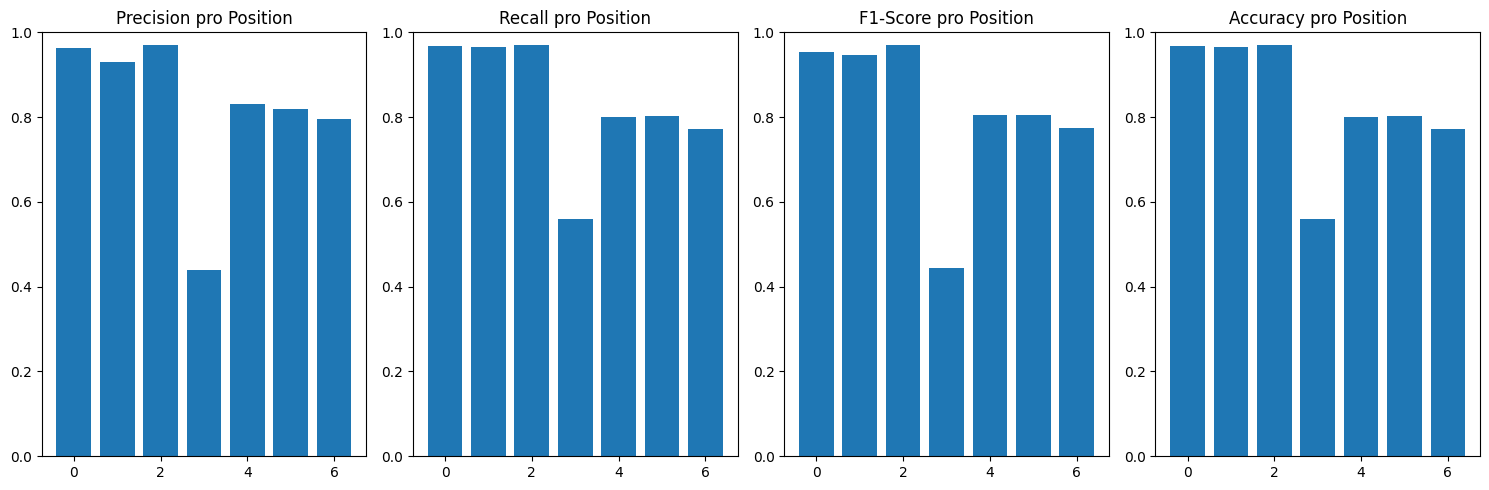

C:\Users\maure\AppData\Local\pypoetry\Cache\virtualenvs\programming-for-modern-machine-learning-XoXAIn3_-py3.12\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 30358 (\N{CJK UNIFIED IDEOGRAPH-7696}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\maure\AppData\Local\pypoetry\Cache\virtualenvs\programming-for-modern-machine-learning-XoXAIn3_-py3.12\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 27818 (\N{CJK UNIFIED IDEOGRAPH-6CAA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\maure\AppData\Local\pypoetry\Cache\virtualenvs\programming-for-modern-machine-learning-XoXAIn3_-py3.12\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 27941 (\N{CJK UNIFIED IDEOGRAPH-6D25}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\maure\AppData\Local\pypoetry\Cache\virtualenvs\programming-for-modern-machine-learning-XoXAIn3_-py3.12\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 28189 (\N{CJK UNIFIED IDEOGRAPH-6E1D}) mi

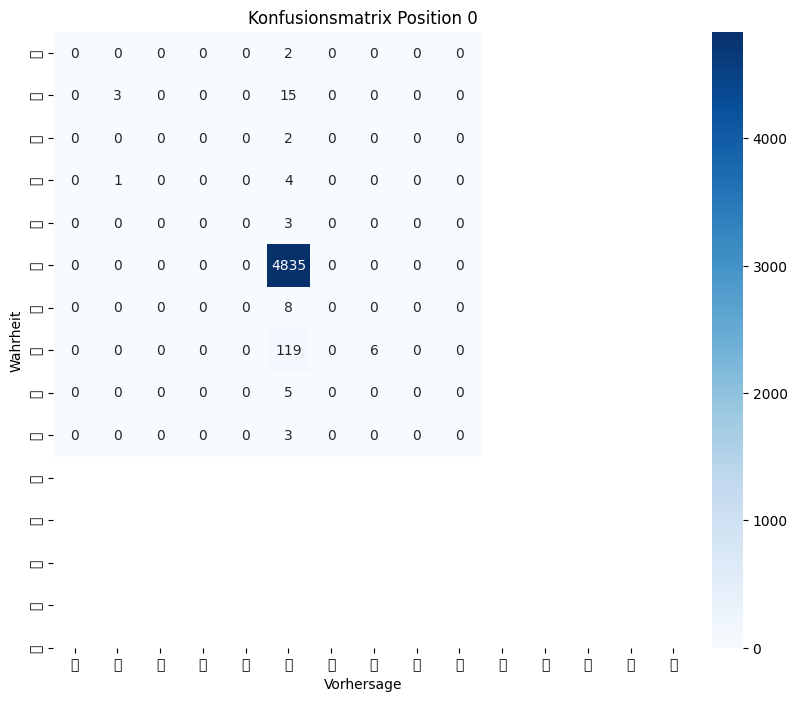

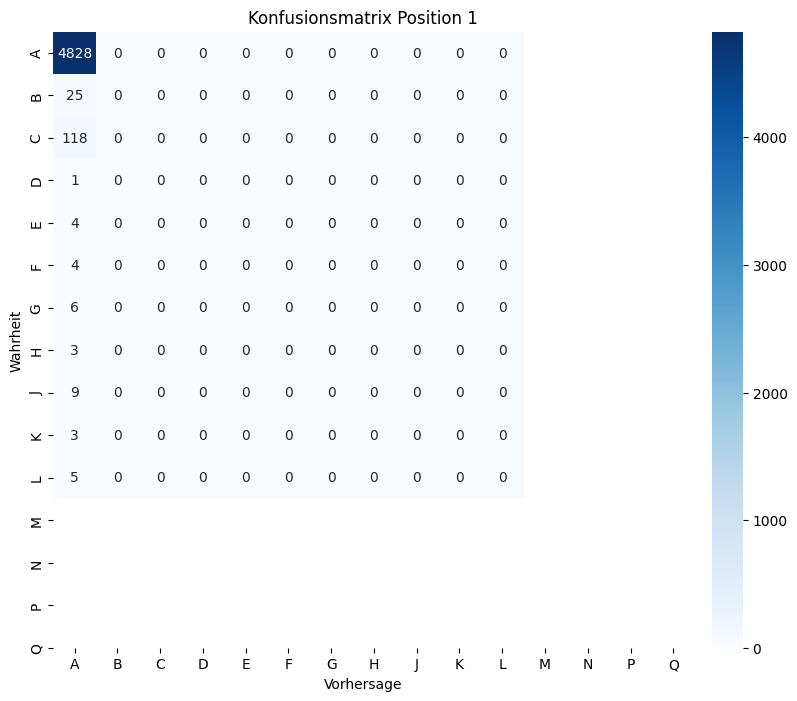


Durchschnittliche korrekte Zeichen pro Kennzeichen: 88.66%
Komplette Kennzeichen-Genauigkeit: 88.66%

Zusätzliche Beispielvorhersagen:
Could not read image: ../dataset/CCPD2020/ccpd_green\test/images\025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg

Bild: 025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg
Tatsächlich: 皖AY339S
Vorhergesagt: None
Keine Übereinstimmung


In [7]:
# ================== DETAILANALYSE DER VORHERSAGEN ==================
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from joblib import load
import seaborn as sns

def calculate_metrics(models, X_test, y_test):
    # Metriken pro Zeichenposition
    position_metrics = []

    for pos in range(7):
        y_true = y_test[pos]
        y_pred = models[pos].predict(X_test)

        # Metriken berechnen
        metrics = {
            'Position': pos,
            'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'F1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'Accuracy': accuracy_score(y_true, y_pred)
        }
        position_metrics.append(metrics)

    # Gesamtmetriken
    total_metrics = {
        'Precision': np.mean([m['Precision'] for m in position_metrics]),
        'Recall': np.mean([m['Recall'] for m in position_metrics]),
        'F1': np.mean([m['F1'] for m in position_metrics]),
        'Accuracy': np.mean([m['Accuracy'] for m in position_metrics])
    }

    return position_metrics, total_metrics

def plot_position_metrics(position_metrics):
    positions = [m['Position'] for m in position_metrics]

    plt.figure(figsize=(15, 5))

    # Precision
    plt.subplot(1, 4, 1)
    plt.bar(positions, [m['Precision'] for m in position_metrics])
    plt.title('Precision pro Position')
    plt.ylim(0, 1)

    # Recall
    plt.subplot(1, 4, 2)
    plt.bar(positions, [m['Recall'] for m in position_metrics])
    plt.title('Recall pro Position')
    plt.ylim(0, 1)

    # F1-Score
    plt.subplot(1, 4, 3)
    plt.bar(positions, [m['F1'] for m in position_metrics])
    plt.title('F1-Score pro Position')
    plt.ylim(0, 1)

    # Accuracy
    plt.subplot(1, 4, 4)
    plt.bar(positions, [m['Accuracy'] for m in position_metrics])
    plt.title('Accuracy pro Position')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title(title)
    plt.xlabel('Vorhersage')
    plt.ylabel('Wahrheit')
    plt.show()

def extended_analysis(models, X_test, y_test):
    # Berechnung der Metriken
    position_metrics, total_metrics = calculate_metrics(models, X_test, y_test)

    # Ausgabe der Ergebnisse
    print("\nDetaillierte Metriken pro Position:")
    for metric in position_metrics:
        print(f"\nPosition {metric['Position']}:")
        print(f"  Precision: {metric['Precision']:.2%}")
        print(f"  Recall:    {metric['Recall']:.2%}")
        print(f"  F1-Score:  {metric['F1']:.2%}")
        print(f"  Accuracy:  {metric['Accuracy']:.2%}")

    print("\nDurchschnittliche Gesamtmetriken:")
    print(f"  Precision: {total_metrics['Precision']:.2%}")
    print(f"  Recall:    {total_metrics['Recall']:.2%}")
    print(f"  F1-Score:  {total_metrics['F1']:.2%}")
    print(f"  Accuracy:  {total_metrics['Accuracy']:.2%}")

    # Visualisierung
    plot_position_metrics(position_metrics)

    # Beispiel-Konfusionsmatrix für Position 0 und 1
    for pos in [0, 1]:
        y_true = y_test[pos]
        y_pred = models[pos].predict(X_test)
        plot_confusion_matrix(y_true, y_pred,
                             classes=CHAR_MAPS[pos][:15],  # Erste 15 Klassen zeigen
                             title=f'Konfusionsmatrix Position {pos}')

# Neue Evaluierungsfunktion für vollständige Platten-Genauigkeit
def calculate_full_accuracy(models, X_test, y_test):
    correct = 0
    total_chars = 0

    for feat, true_labels in zip(X_test, zip(*y_test)):
        pred = [model.predict([feat])[0] for model in models]
        correct += sum(p == t for p, t in zip(pred, true_labels))
        if all(p == t for p, t in zip(pred, true_labels)):
            correct += 1
        total_chars += 7

    print(f"\nDurchschnittliche korrekte Zeichen pro Kennzeichen: {correct/total_chars:.2%}")
    print(f"Komplette Kennzeichen-Genauigkeit: {correct/ (7 * len(X_test)):.2%}")

# In der Testzelle danach:
def load_and_test_models(base_dir):
    # Modelle laden
    models = [load(f'position_{i}_model.joblib') for i in range(7)]

    # Testdaten laden
    X_test, y_test = load_dataset(base_dir, "test")

    # 1. Detailanalyse
    extended_analysis(models, X_test, y_test)

    # 2. Vollständige Genauigkeit
    calculate_full_accuracy(models, X_test, y_test)

    # 3. Zusätzliche Beispiele
    print("\nZusätzliche Beispielvorhersagen:")
    test_images = [
        "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg",
        # Weitere Beispielbilder hier einfügen
    ]

    for img_name in test_images:
        img_path = os.path.join(base_dir, "test/images", img_name)
        actual = ''.join(parse_labels(img_name))
        predicted = predict_license_plate(img_path, models)
        print(f"\nBild: {img_name}")
        print(f"Tatsächlich: {actual}")
        print(f"Vorhergesagt: {predicted}")
        if not predicted:
            print(f"Keine Übereinstimmung")
        else:
            print(f"Übereinstimmung: {sum(a==p for a,p in zip(actual, predicted))}/7 Zeichen")

# Ausführen mit:
BASE_DIR = "../dataset/CCPD2020/ccpd_green"
load_and_test_models(BASE_DIR)